In [1]:
import psycopg2
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib

latex = False

if latex:
    matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })

In [2]:
MIN_LOS_ICU = 24

# Load Data

### From SQL

In [ ]:
# Connect to db
conn = psycopg2.connect(host='localhost', port=5433, dbname='mimic', user='postgres', password='postgres')
cur = conn.cursor() 

# Read vital signs
vitals = pd.read_sql_query(f'SELECT * FROM mimiciii.vital_resampled_min{MIN_LOS_ICU:d}h;', conn)

# Read in labs values
labs = pd.read_sql_query(f'SELECT * FROM mimiciii.lab_resampled_min{MIN_LOS_ICU:d}h;', conn)

# Read demographics
demographics = pd.read_sql_query(f'SELECT * FROM mimiciii.demographics_min{MIN_LOS_ICU:d}h;', conn)

# Close the cursor and connection to so the server can allocate bandwidth to other requests
cur.close()
conn.close()

### From File

In [3]:
data_path = f'data/min{MIN_LOS_ICU:d}h/'

demographics = pd.read_pickle(data_path + f'demographics_min{MIN_LOS_ICU:d}h.pickle')
vitals = pd.read_pickle(data_path + f'vitals_min{MIN_LOS_ICU:d}h.pickle')
labs = pd.read_pickle(data_path + f'labs_min{MIN_LOS_ICU:d}h.pickle')

# Preprocess data:

In [4]:
demographics['los_icu_hours'] =     demographics['los_icu'] * 24

demographics['los_icu_bin'] =       pd.cut(demographics['los_icu_hours'],
                                        bins=[8, 15, 23, 31, 39, 47, 55, 63, 71, max(demographics['los_icu_hours'])],
                                        labels=['8-15', '16-23', '24-31', '32-39', '40-47', '48-55', '56-63', '64-71', '>72']
                                    ).astype(str)

demographics['admission_age_bin'] = pd.cut(demographics['admission_age'],
                                        bins=[0, 29, 59, 89, max(demographics['admission_age'])],
                                        labels=['0-29', '30-59', '60-89', '>90']
                                    ).astype(str)

# Analysis

## Basic data description and overview

Describe vitals

In [5]:
vitals.head(5)

,icustay_id,charttime,heartrate,sysbp,diasbp,meanbp,resprate,tempc,spo2,label_death_icu
0,200007,2109-02-17 09:00:00,87.0,125.5,70.5,88.833351,16.0,36.388889,96.5,0
1,200007,2109-02-17 10:00:00,87.0,125.5,70.5,88.833351,16.0,36.388889,96.5,0
2,200007,2109-02-17 11:00:00,87.0,125.5,70.5,88.833351,16.0,36.388889,96.5,0
3,200007,2109-02-17 12:00:00,87.0,125.5,70.5,88.833351,16.0,36.388889,96.5,0
4,200007,2109-02-17 13:00:00,83.0,118.0,60.0,79.333298,15.0,36.388889,97.0,0


In [6]:
vitals.describe()

,icustay_id,heartrate,sysbp,diasbp,meanbp,resprate,tempc,spo2,label_death_icu
count,863025.000000,863025.000000,863025.000000,863025.000000,863025.000000,863025.000000,863025.000000,863025.000000,863025.00000
mean,250244.909606,83.782040,121.029616,61.146181,78.746664,18.834240,36.734804,96.737532,0.04018
std,28989.173029,16.815361,21.318167,14.315899,15.040950,5.214268,2.139353,4.934316,0.19638
min,200007.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.00000
25%,225176.000000,72.000000,106.000000,51.500000,68.750000,15.000000,36.388889,95.000000,0.00000
50%,250440.000000,83.000000,119.000000,60.000000,77.000000,18.000000,36.833333,97.000000,0.00000
75%,275272.000000,94.000000,134.000000,70.000000,87.500000,22.000000,37.277777,99.000000,0.00000
max,299999.000000,216.000000,274.000000,231.000000,294.000000,69.000000,42.166668,100.000000,1.00000


Describe labs

In [7]:
labs.head(5)

,icustay_id,charttime,albumin,bun,bilirubin,lactate,bicarbonate,bands,chloride,creatinine,glucose,hemoglobin,hematocrit,platelet,potassium,ptt,sodium,wbc,label_death_icu
0,200007,2109-02-17 09:00:00,4.0,10.0,-1.0,-1.0,22.0,-1.0,103.0,0.8,233.0,13.3,38.1,247.0,3.8,49.6,138.0,11.2,0
1,200007,2109-02-17 17:00:00,4.0,10.0,-1.0,-1.0,22.0,-1.0,103.0,0.8,233.0,13.3,38.1,247.0,3.8,49.6,138.0,11.2,0
2,200007,2109-02-18 01:00:00,4.0,8.0,-1.0,-1.0,24.0,-1.0,101.0,0.8,217.0,13.3,38.1,247.0,3.9,51.8,135.0,11.2,0
3,200007,2109-02-18 09:00:00,4.0,8.0,-1.0,-1.0,24.0,-1.0,101.0,0.8,217.0,12.8,37.4,225.0,3.9,51.8,135.0,9.4,0
4,200007,2109-02-18 17:00:00,4.0,8.0,-1.0,-1.0,24.0,-1.0,101.0,0.8,217.0,12.8,37.4,214.0,3.6,51.8,135.0,9.4,0


In [8]:
labs.describe()

,icustay_id,albumin,bun,bilirubin,lactate,bicarbonate,bands,chloride,creatinine,glucose,hemoglobin,hematocrit,platelet,potassium,ptt,sodium,wbc,label_death_icu
count,116189.000000,116189.000000,116189.000000,116189.000000,116189.000000,116189.000000,116189.000000,116189.000000,116189.000000,116189.000000,116189.000000,116189.000000,116189.000000,116189.000000,116189.000000,116189.000000,116189.000000,116189.000000
mean,250240.870960,0.357113,21.615785,-0.017988,0.238766,24.399929,-0.366775,105.026728,1.206749,127.115876,10.783693,31.801413,208.408154,4.057891,30.158916,137.958137,11.185331,0.040426
std,28990.647011,1.972072,17.709943,2.603907,1.864048,4.369063,3.298165,8.646011,1.301207,51.128432,1.969890,5.332206,104.611665,0.702488,21.187943,10.892987,7.314747,0.196956
min,200007.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,225142.000000,-1.000000,11.000000,-1.000000,-1.000000,22.000000,-1.000000,102.000000,0.700000,99.000000,9.600000,28.250000,142.000000,3.700000,24.500000,136.000000,7.600000,0.000000
50%,250440.000000,-1.000000,16.000000,-1.000000,-1.000000,25.000000,-1.000000,106.000000,0.900000,118.000000,10.700000,31.400000,193.000000,4.000000,28.700000,139.000000,10.200000,0.000000
75%,275271.000000,2.700000,25.000000,0.500000,1.400000,27.000000,-1.000000,109.000000,1.200000,142.000000,12.000000,35.100000,254.000000,4.400000,34.600000,141.000000,13.400000,0.000000
max,299999.000000,6.300000,266.000000,59.500000,27.700000,52.000000,66.000000,145.000000,28.850000,1340.000000,21.950000,70.700000,2132.000000,26.500000,150.000000,180.000000,462.600000,1.000000


Describe demographics

In [9]:
demographics[['icustay_id','intime','outtime','label_death_icu']].head(5)

,icustay_id,intime,outtime,label_death_icu
0,200007,2109-02-17 09:00:00,2109-02-18 17:03:12,0
1,200009,2189-11-30 11:43:00,2189-12-02 14:17:37,0
2,200014,2105-02-16 23:15:00,2105-02-18 16:53:29,0
3,200021,2114-12-26 20:00:00,2114-12-27 22:46:28,0
4,200028,2133-10-29 17:30:00,2133-11-01 14:55:14,0


In [10]:
demographics.describe()

,icustay_id,subject_id,hadm_id,los_hospital,admission_age,hospital_expire_flag,hospstay_seq,los_icu,icustay_seq,label_death_icu,los_icu_hours
count,18281.000000,18281.000000,18281.000000,18281.000000,18281.000000,18281.000000,18281.0,18281.000000,18281.0,18281.000000,18281.000000
mean,250168.166129,39273.689842,150184.886111,7.362273,74.569358,0.069416,1.0,1.800141,1.0,0.043980,43.203388
std,28994.035557,29491.191401,29016.639512,7.149613,55.881582,0.254168,0.0,0.568930,0.0,0.205056,13.654315
min,200007.000000,4.000000,100003.000000,0.038194,14.911114,0.000000,1.0,1.000012,1.0,0.000000,24.000278
25%,225074.000000,14432.000000,124831.000000,3.724306,52.062905,0.000000,1.0,1.272662,1.0,0.000000,30.543889
50%,250261.000000,28984.000000,150642.000000,5.611111,65.183192,0.000000,1.0,1.770139,1.0,0.000000,42.483333
75%,275169.000000,64232.000000,175445.000000,8.529861,77.563191,0.000000,1.0,2.190278,1.0,0.000000,52.566667
max,299999.000000,99999.000000,199998.000000,206.425694,306.485032,1.000000,1.0,2.999988,1.0,1.000000,71.999722


Check if there is empty data

In [11]:
demographics.isnull().sum()

icustay_id                         0
subject_id                         0
hadm_id                            0
gender                             0
dod                            11962
admittime                          0
dischtime                          0
los_hospital                       0
admission_age                      0
ethnicity                          0
ethnicity_grouped                  0
hospital_expire_flag               0
hospstay_seq                       0
first_hosp_stay                    0
intime                             0
outtime                            0
los_icu                            0
icustay_seq                        0
first_icu_stay_current_hosp        0
first_icu_stay_patient             0
first_careunit                     0
deathtime_icu                  17477
label_death_icu                    0
intime_old                         0
los_icu_hours                      0
los_icu_bin                        0
admission_age_bin                  0
d

In [12]:
labs.isnull().sum().sum()

0

In [13]:
vitals.isnull().sum().sum()

0

## Check timings of measurements:

In [14]:
timings = demographics[['icustay_id', 'intime', 'outtime']].copy()
timings = timings.sort_values('icustay_id').set_index('icustay_id')

Check labs

In [15]:
labs_grouped = labs[['icustay_id', 'charttime']].copy().groupby('icustay_id')
labs_grouped.sort = True

# Calculate offset between first lab and intime:
timings['offset_first_lab'] = labs_grouped.charttime.min()
timings['offset_first_lab'] = (timings['offset_first_lab'] - timings['intime']) / timedelta(hours=1)

# Calculate offset between last lab and outtime:
timings['offset_last_lab'] = labs_grouped.charttime.max()
timings['offset_last_lab'] = (timings['offset_last_lab'] - timings['outtime']) / timedelta(hours=1)

# Calculate number of labs preceding intime:
timings['n_early_labs'] = [(labs_grouped.get_group(i).charttime.to_numpy() < timings.loc[[i]].intime.to_numpy()).sum() for i in timings.index]

# Calculate number of labs after outtime:
timings['n_late_labs'] = [(labs_grouped.get_group(i).charttime.to_numpy() > timings.loc[[i]].outtime.to_numpy()).sum() for i in timings.index]

# Calculate number of labs in between intime and outtime:
timings['n_labs']  = [len(labs_grouped.get_group(i)) for i in timings.index]
timings['n_labs'] -= timings['n_early_labs']
timings['n_labs'] -= timings['n_late_labs']

del labs_grouped

Check vitals

In [16]:
vitals_grouped = vitals[['icustay_id', 'charttime']].copy().groupby('icustay_id')
vitals_grouped.sort = True

# Calculate offset between first vital and intime:
timings['offset_first_vital'] = vitals_grouped.charttime.min()
timings['offset_first_vital'] = (timings['offset_first_vital'] - timings['intime']) / timedelta(hours=1)

# Calculate offset between last vital and outtime:
timings['offset_last_vital'] = vitals_grouped.charttime.max()
timings['offset_last_vital'] = (timings['offset_last_vital'] - timings['outtime']) / timedelta(hours=1)

# Calculate number of vitals preceding intime:
timings['n_early_vitals'] = [(vitals_grouped.get_group(i).charttime.to_numpy() < timings.loc[[i]].intime.to_numpy()).sum() for i in timings.index]

# Calculate number of vitals after outtime:
timings['n_late_vitals'] = [(vitals_grouped.get_group(i).charttime.to_numpy() > timings.loc[[i]].outtime.to_numpy()).sum() for i in timings.index]

# Calculate number of vitals in between intime and outtime:
timings['n_vitals']  = [len(vitals_grouped.get_group(i)) for i in timings.index]
timings['n_vitals'] -= timings['n_early_vitals']
timings['n_vitals'] -= timings['n_late_vitals']

del vitals_grouped

Describe timings

In [17]:
print(
    'All labs and vitals start at the same time: ',
    (timings['offset_first_vital'] == timings['offset_first_lab']).to_numpy().all()
)
timings.describe()

All labs and vitals start at the same time:  True


,offset_first_lab,offset_last_lab,n_early_labs,n_late_labs,n_labs,offset_first_vital,offset_last_vital,n_early_vitals,n_late_vitals,n_vitals
count,18281.000000,18281.000000,18281.000000,18281.000000,18281.000000,18281.000000,18281.000000,18281.000000,18281.000000,18281.000000
mean,0.005372,-0.352220,0.324545,0.528800,5.502380,0.005372,3.010835,0.324545,4.242383,42.641923
std,0.267981,6.003835,0.468217,0.671028,1.752712,0.267981,5.588021,0.468217,4.794594,13.644943
min,-0.500000,-44.616667,0.000000,0.000000,2.000000,-0.500000,-42.616667,0.000000,0.000000,15.000000
25%,-0.166667,-5.108611,0.000000,0.000000,4.000000,-0.166667,-1.544722,0.000000,0.000000,30.000000
50%,0.000000,-1.511111,0.000000,0.000000,5.000000,0.000000,0.174167,0.000000,1.000000,42.000000
75%,0.200000,4.930000,1.000000,1.000000,7.000000,0.200000,8.698333,1.000000,9.000000,52.000000
max,0.500000,12.491111,1.000000,2.000000,9.000000,0.500000,12.498889,1.000000,13.000000,72.000000


In [18]:
timings.head(5)

,intime,outtime,offset_first_lab,offset_last_lab,n_early_labs,n_late_labs,n_labs,offset_first_vital,offset_last_vital,n_early_vitals,n_late_vitals,n_vitals
icustay_id,,,,,,,,,,,,
200007,2109-02-17 09:00:00,2109-02-18 17:03:12,0.000000,-0.053333,0,0,5,0.000000,4.946667,0,5,33
200009,2189-11-30 11:43:00,2189-12-02 14:17:37,0.283333,-2.293611,0,0,7,0.283333,-1.293611,0,0,50
200014,2105-02-16 23:15:00,2105-02-18 16:53:29,-0.250000,-1.891389,1,0,5,-0.250000,-1.891389,1,0,40
200021,2114-12-26 20:00:00,2114-12-27 22:46:28,0.000000,5.225556,0,1,4,0.000000,6.225556,0,7,27
200028,2133-10-29 17:30:00,2133-11-01 14:55:14,0.500000,-4.920556,0,0,9,0.500000,-0.920556,0,0,69


In [19]:
len(timings[timings['n_early_labs']>1])

0

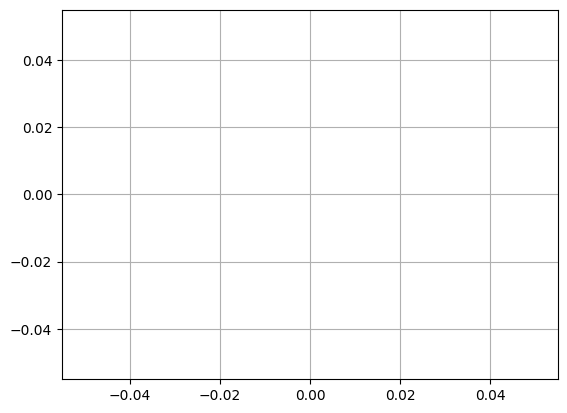

In [20]:
#timings.offset_first_vital.hist(bins=np.arange(timings.offset_first_vital.min().round()-.5, timings.offset_first_vital.max().round()+.5))
timings.offset_first_vital.hist(bins=np.arange(timings.offset_first_vital.min().round()-.5, timings.offset_first_vital.max().round()+.5))
plt.show()

### Overview of the patient's length of stay per bins

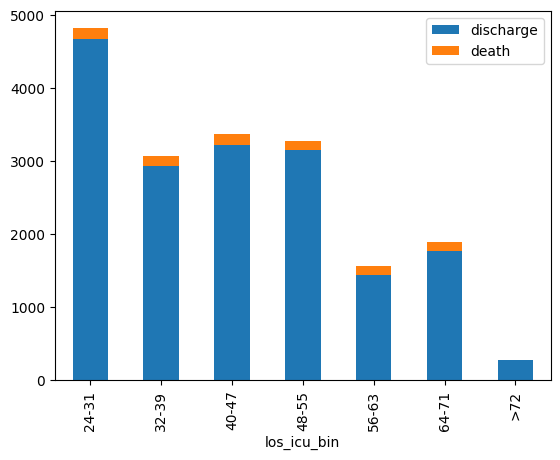

In [21]:
icu_length_by_class = demographics.groupby("los_icu_bin")['label_death_icu'].value_counts() 
icu_length_by_class.unstack().plot(kind='bar', stacked= True) 
data_imputed = demographics.drop(columns=['los_icu_bin'])
plt.legend(labels=["discharge","death"])
plt.show()

## Length of stay in ICU
Focusing on the demographics "los_icu" we see that there is a big difference between the last quantile (90%) and the maximum value. 

In [22]:
demo_q = demographics['los_icu'].quantile(.9)
print(f"90% Quantile length of stay: {demo_q*24.:.2f}h")

90% Quantile length of stay: 64.66h


In [23]:
print("Patients above 90% quantile: \n", demographics[demographics.los_icu > demo_q].label_death_icu.value_counts())
print("Total number of patients: \n", demographics.label_death_icu.value_counts())

Patients above 90% quantile: 
 0    1727
1     101
Name: label_death_icu, dtype: int64
Total number of patients: 
 0    17477
1      804
Name: label_death_icu, dtype: int64


## Data distribution for ICU length of stay

Patient's ICU length of stay per hour

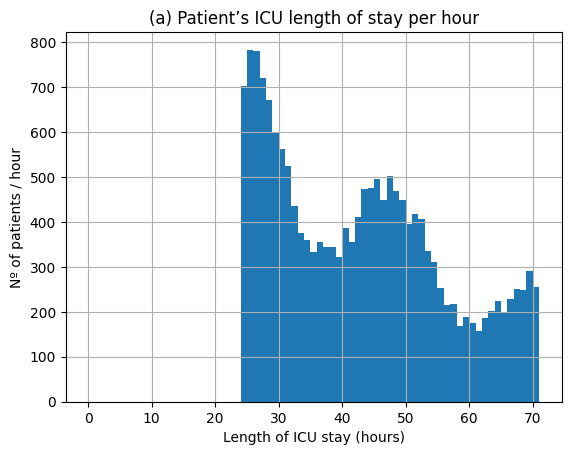

In [24]:
demographics.hist(column='los_icu_hours', bins=np.arange(demographics.los_icu_hours.max()))
plt.ylabel('Nº of patients / hour')
plt.xlabel('Length of ICU stay (hours)')
plt.title("(a) Patient’s ICU length of stay per hour")
#plt.savefig("Exploratory analysis_a.pdf", format="pdf", bbox_inches="tight")
plt.show()

Patient's ICU length of stay for 72h in groups of 8 h

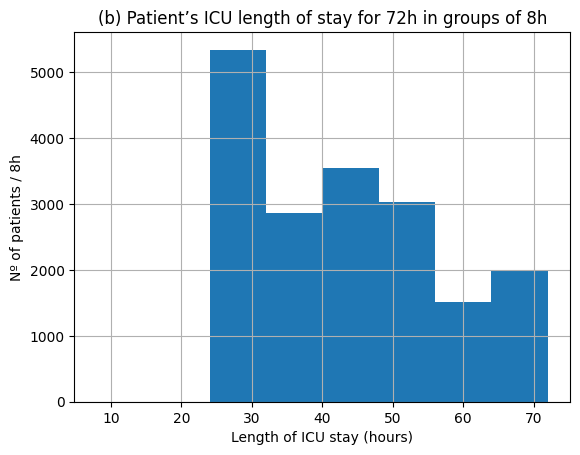

In [25]:
demographics.hist(column='los_icu_hours', bins=range(8, MIN_LOS_ICU + 49, 8))
plt.ylabel('Nº of patients / 8h')
plt.xlabel('Length of ICU stay (hours)')
plt.title("(b) Patient’s ICU length of stay for 72h in groups of 8h")
#plt.savefig("Exploratory analysis_b.pdf", format="pdf", bbox_inches="tight")
plt.show()

Death patient's ICU length of stay per 1 h

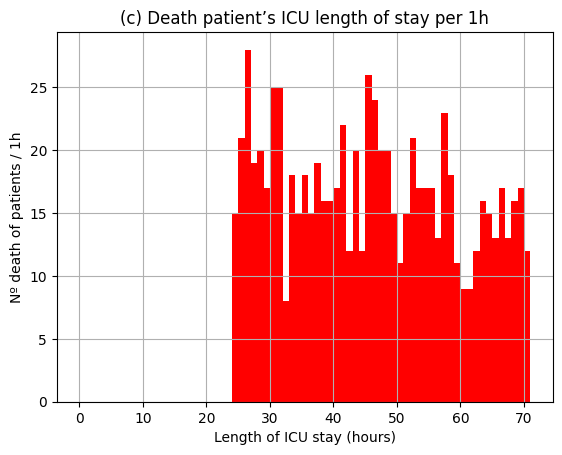

In [26]:
demographics_death = demographics[demographics.label_death_icu==1]
demographics_death.hist(column='los_icu_hours', bins=np.arange(72), color='red')
plt.ylabel('Nº death of patients / 1h')
plt.xlabel('Length of ICU stay (hours)')
plt.title("(c) Death patient’s ICU length of stay per 1h")
#plt.savefig("Exploratory analysis_c.pdf", format="pdf", bbox_inches="tight")
plt.show()

Death patient's ICU length of stau for 72 h in groups of 8 h 

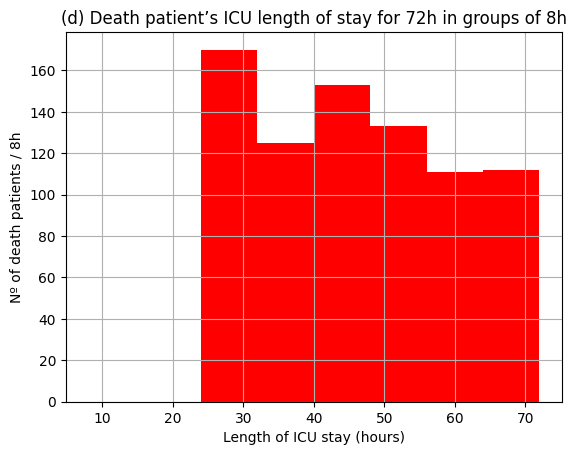

In [27]:
demographics_death.hist(column='los_icu_hours', bins=range(8, MIN_LOS_ICU + 49, 8), color='red')
plt.ylabel('Nº of death patients / 8h')
plt.xlabel('Length of ICU stay (hours)')
plt.title("(d) Death patient’s ICU length of stay for 72h in groups of 8h")
#plt.savefig("Exploratory analysis_d.pdf", format="pdf", bbox_inches="tight")
plt.show()

Patient's count for a minimum length of stay of 8 h, 16 h, 24 h, 32 h, 40 h, 48 h, 72 h

In [28]:
pat_window = pd.DataFrame()

for t in range(8, MIN_LOS_ICU + 48, 8):
    pat_window[f'>={t:d}h'] =  demographics[demographics.los_icu_hours >= t].label_death_icu.value_counts()

pat_window.loc['Total']= pat_window.sum(numeric_only=True, axis=0)
pat_window


,>=8h,>=16h,>=24h,>=32h,>=40h,>=48h,>=56h,>=64h
0,17477,17477,17477,12307,9564,6167,3267,1868
1,804,804,804,634,509,356,223,112
Total,18281,18281,18281,12941,10073,6523,3490,1980


## Print patient distribution:

In [29]:
f = 100. / len(demographics.icustay_id.unique())

def print_distribution(column=None):
    # Actual printing happens here:
    def __print_internal(data):
        if len(data) > 0:
            label_counts = data['label_death_icu'].value_counts()
            latex = ""

            if 1 in label_counts:
                print(f"  Number of ICU deaths:       {label_counts[1]:6d} ({label_counts[1]/label_counts.sum()*100.:5.1f}%)")
                latex += f"& ${label_counts[1]:6,d}$ & ${label_counts[1]*f:5.1f}\%$ "
            else:
                print(f"  Number of ICU deaths:            0 (  0.0%)")
                latex += f"& $     0$ & $  0.0\%$ "

            
            if 0 in label_counts:
                print(f"  Number of ICU discharges:   {label_counts[0]:6d} ({label_counts[0]/label_counts.sum()*100.:5.1f}%)")
                latex += f"& ${label_counts[0]:6,d}$ & ${label_counts[0]*f:5.1f}\%$ "
            else:
                print(f"  Number of ICU discharges:        0 (  0.0%)")
                latex += f"& $     0$ & $  0.0\%$ "

            latex += f"& ${label_counts.sum():6,d}$ "
            print(f"Latex: '{latex:s}'")

    # Print overall class distribution if column is None:
    if column == None:
        __print_internal(demographics)

    # Print class distribution of column:
    else:
        for key in demographics[column].unique():
            print(f"'{key:s}':")
            __print_internal(demographics[demographics[column]==key])
            print()

In [30]:
print_distribution()

  Number of ICU deaths:          804 (  4.4%)
  Number of ICU discharges:    17477 ( 95.6%)
Latex: '& $   804$ & $  4.4\%$ & $17,477$ & $ 95.6\%$ & $18,281$ '


Print gender distribution:

In [31]:
print_distribution('gender')

'M':
  Number of ICU deaths:          420 (  4.0%)
  Number of ICU discharges:    10075 ( 96.0%)
Latex: '& $   420$ & $  2.3\%$ & $10,075$ & $ 55.1\%$ & $10,495$ '

'F':
  Number of ICU deaths:          384 (  4.9%)
  Number of ICU discharges:     7402 ( 95.1%)
Latex: '& $   384$ & $  2.1\%$ & $ 7,402$ & $ 40.5\%$ & $ 7,786$ '



Print ethnicity distribution:

In [32]:
print_distribution('ethnicity_grouped')

'white':
  Number of ICU deaths:          546 (  4.2%)
  Number of ICU discharges:    12602 ( 95.8%)
Latex: '& $   546$ & $  3.0\%$ & $12,602$ & $ 68.9\%$ & $13,148$ '

'unknown':
  Number of ICU deaths:          153 (  7.2%)
  Number of ICU discharges:     1975 ( 92.8%)
Latex: '& $   153$ & $  0.8\%$ & $ 1,975$ & $ 10.8\%$ & $ 2,128$ '

'black':
  Number of ICU deaths:           40 (  2.8%)
  Number of ICU discharges:     1400 ( 97.2%)
Latex: '& $    40$ & $  0.2\%$ & $ 1,400$ & $  7.7\%$ & $ 1,440$ '

'other':
  Number of ICU deaths:           22 (  4.4%)
  Number of ICU discharges:      477 ( 95.6%)
Latex: '& $    22$ & $  0.1\%$ & $   477$ & $  2.6\%$ & $   499$ '

'asian':
  Number of ICU deaths:           23 (  5.1%)
  Number of ICU discharges:      424 ( 94.9%)
Latex: '& $    23$ & $  0.1\%$ & $   424$ & $  2.3\%$ & $   447$ '

'hispanic':
  Number of ICU deaths:           20 (  3.3%)
  Number of ICU discharges:      589 ( 96.7%)
Latex: '& $    20$ & $  0.1\%$ & $   589$ & $  3.

Print age distribution:

In [33]:
print_distribution('admission_age_bin')

'30-59':
  Number of ICU deaths:          177 (  3.0%)
  Number of ICU discharges:     5777 ( 97.0%)
Latex: '& $   177$ & $  1.0\%$ & $ 5,777$ & $ 31.6\%$ & $ 5,954$ '

'60-89':
  Number of ICU deaths:          525 (  5.0%)
  Number of ICU discharges:     9920 ( 95.0%)
Latex: '& $   525$ & $  2.9\%$ & $ 9,920$ & $ 54.3\%$ & $10,445$ '

'0-29':
  Number of ICU deaths:           18 (  2.0%)
  Number of ICU discharges:      892 ( 98.0%)
Latex: '& $    18$ & $  0.1\%$ & $   892$ & $  4.9\%$ & $   910$ '

'>90':
  Number of ICU deaths:           84 (  8.6%)
  Number of ICU discharges:      888 ( 91.4%)
Latex: '& $    84$ & $  0.5\%$ & $   888$ & $  4.9\%$ & $   972$ '

